# MAST Plasma Volume Challenge

This challenge requires you to predict plasma volume from frames captured by a wide-angle visible spectrum camera on the CCFE's Mega Ampere Spherical Tokamak (MAST).

> **Note:** Before proceeding, run the `Plasma Volume Dataset.ipynb` notebook to download the required dataset from the FAIR-MAST server. This ensures you have the necessary data files in the `fair_mast_data/plasma_volume` directory.

## Overview

This is the second of three Data Science challenges for the ITER International School 2024.

The animation below shows footage from a wide-angle proton bullet camera installed on MAST. This visible spectrum camera captures high frame-rate recordings showing the complete plasma cross-section on both sides of the central column. Similar cameras first captured visual recordings of ELM structures on MAST and AUG in 2007.

![MAST Proton Camera Animation](../media/images/c3_proton_camera.gif)

**Challenge Goal:** Develop a machine learning algorithm that predicts plasma volume from a single frame of the camera feed.

This challenge introduces techniques for inferring parameters from 2D image data.

The MAST Data Catalog provided the data for this competition. Thanks to the curators Samuel Jackson, Nathan Cummings, Saiful Khan, and the wider MAST community for this FAIR dataset initiative.

## Background

The image below shows the maximum plasma volume achieved for all shots in the MAST M9 campaign. These experiments were the last performed before the major upgrade to create the current MAST-U machine.

![Maximum Plasma Volume](../media/images/plasma_volume.png)

Maximum plasma volumes range from ~6 to ~10 cubic meters.

This challenge requires you to predict plasma volume from camera imagery.

## Dataset 

The `./fair_mast_data/plasma_volume` directory contains all necessary files for this challenge.

### Files
- `train.nc` - Training dataset in netCDF format
- `test.nc` - Test dataset in netCDF format

### Data Structure
- `shot_id` - Unique identifier for each shot
- `frame` - Stack of camera frames with dimensions (shot_id, height, width)

## Example

Both training and test datasets use the netCDF format. This self-describing format includes important metadata such as image dimensions alongside the data itself.

After importing the prerequisite libraries, load the datasets using the xarray library as shown below.

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.decomposition
import sklearn.ensemble
import sklearn.kernel_ridge
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import xarray as xr

path = pathlib.Path().absolute().parent / "fair_mast_data/plasma_volume"

try:
    with (
        xr.open_dataset(path / "train.nc") as train,
        xr.open_dataset(path / "test.nc") as test,
    ):
        train = train.load()
        test = test.load()
except FileNotFoundError as error:
    raise FileNotFoundError(
        "Please run the `Plasma Volume Dataset.ipynb` notebook to download the "
        "required dataset from the FAIR-MAST server") from error



**Important:** The camera images have dimensions (shot_id, height, width). You need to reshape this data to the (n_samples, n_features) format required by scikit-learn. After reshaping, you can split the data using standard train-test split techniques.

In [4]:
X = train.frame.values.reshape(train.sizes["shot_id"], -1)
y = train.volume

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=7
)


## Dimensionality Reduction

The camera frames have high dimensionality. To make the problem computationally tractable, we apply dimensionality reduction techniques.

The pipeline below uses KernelPCA decomposition as a preprocessing step. This component provides several hyperparameters you can tune to improve model accuracy.

In [5]:
pipeline = sklearn.pipeline.make_pipeline(
    sklearn.decomposition.KernelPCA(n_components=25),
    sklearn.linear_model.LinearRegression(),
)


## Model Training and Evaluation

With the preprocessing pipeline set up, fit the model to your training data and evaluate its performance on the test set.

### R² Score (Coefficient of Determination)

We use the R² score to evaluate model performance. This metric indicates the proportion of variance in the dependent variable (plasma volume) that can be predicted from the independent variables (camera frame data).

- **R² = 1.0**: Perfect predictions (model explains 100% of the variance)
- **R² = 0.0**: Model performs no better than always predicting the mean value
- **R² < 0.0**: Model performs worse than predicting the mean value

For this plasma volume prediction task, R² values closer to 1.0 indicate better model performance.

In [ ]:
# Train the model on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_predict = pipeline.predict(X_test)

# Calculate R² score (coefficient of determination)
# Higher values indicate better model fit (1.0 is perfect, 0.0 is equivalent to predicting the mean)
R2 = sklearn.metrics.r2_score(y_test, y_predict)
print(f"Model R²: {R2:.3f} (higher is better)")


model R2 0.692


## Solution Submission

Prepare your solution file using the same approach as the plasma_current competition. Remember to reshape the test frames to match the (n_samples, n_features) format that your model expects.

In [7]:
volume = pipeline.predict(test.frame.values.reshape(test.sizes["shot_id"], -1))
solution = pd.DataFrame(
    {"plasma_volume": volume}, index=pd.Index(test.shot_id, name="shot_id")
)
solution.to_csv(path / "linear_regression.csv")

In [ ]:
# Let's improve our model with hyperparameter tuning

from sklearn.model_selection import GridSearchCV
import sklearn.metrics
import pandas as pd

# Define parameter grid
param_grid = {
    'kernelpca__n_components': [25, 50, 100],
    'kernelpca__kernel': ['linear', 'rbf', 'poly'],
    'linearregression__fit_intercept': [True, False]
}

# Create grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    verbose=1
)

# Train the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.3f}")

# Evaluate on test set
best_model = grid_search.best_estimator_
y_predict_best = best_model.predict(X_test)
R2_best = sklearn.metrics.r2_score(y_test, y_predict_best)
print(f"Best model R2: {R2_best:.3f}")

# Generate final predictions
best_volume = best_model.predict(test.frame.values.reshape(test.sizes["shot_id"], -1))
best_solution = pd.DataFrame(
    {"plasma_volume": best_volume}, index=pd.Index(test.shot_id, name="shot_id")
)
best_solution.to_csv(path / "optimized_regression.csv")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'kernelpca__kernel': 'linear', 'kernelpca__n_components': 50, 'linearregression__fit_intercept': True}
Best CV score: 0.648
Best model R2: 0.732


## Model Performance Visualization

The plot below compares predicted plasma volume values against ground truth measurements. This visualization helps assess how well our model performs across the range of plasma volumes.

- **Perfect predictions** would fall along the dashed gray line (y = x)
- **Points above the line** represent overestimations (predicted > actual)
- **Points below the line** represent underestimations (predicted < actual)

### Understanding the R² Score

The R² score (coefficient of determination) provides a statistical measure of how well the model's predictions approximate the actual data points:

- **R² = 1.0**: The model perfectly explains all variation in the data
- **R² = 0.8**: The model explains 80% of the variance in the plasma volume
- **R² = 0.5**: Only half of the variance is explained by the model
- **R² ≤ 0**: The model provides no useful information for predicting plasma volume

Unlike error metrics (where lower is better), higher R² values indicate superior model performance. The R² score is also scale-independent, making it useful for comparing model performance across different datasets and target variables.

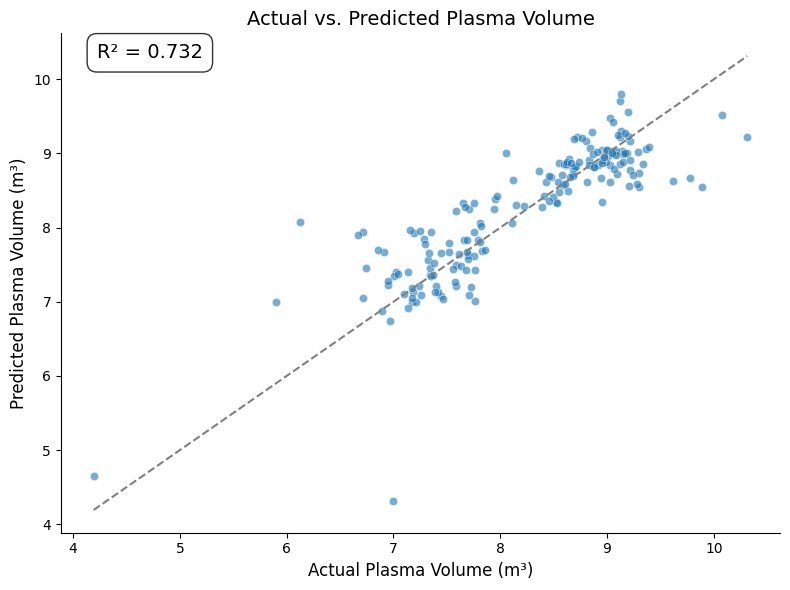

In [16]:
# Visualize model performance using seaborn
plt.figure(figsize=(8, 6))

# Create a DataFrame with actual and predicted values for easy plotting
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_predict_best
})

sns.scatterplot(    
    x='Actual', 
    y='Predicted', 
    data=results_df,
    alpha=0.6,
    )

# Add perfect prediction line (y=x)
plt.plot(
    [results_df['Actual'].min(), results_df['Actual'].max()], 
    [results_df['Actual'].min(), results_df['Actual'].max()], 
    '--', 
    color='gray'
)

# Annotate with R2 score
plt.annotate(
    f'R² = {R2_best:.3f}', 
    xy=(0.05, 0.95), 
    xycoords='axes fraction',
    fontsize=14, 
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
)

# Set labels and title
plt.xlabel('Actual Plasma Volume (m³)', fontsize=12)
plt.ylabel('Predicted Plasma Volume (m³)', fontsize=12)
plt.title('Actual vs. Predicted Plasma Volume', fontsize=14)
sns.despine()
plt.tight_layout()

# Show the plot
plt.show()